In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve, KFold, train_test_split
from sklearn import naive_bayes
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

RANDOM_SEED = 6    # Set a random seed for reproducibility!

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

Using TensorFlow backend.


/kaggle/input/h1n1-dataset/training_set_features.csv
/kaggle/input/h1n1-dataset/training_set_labels.csv
/kaggle/input/h1n1-dataset/test_set_features.csv
/kaggle/input/h1n1-dataset/submission_format.csv
/kaggle/input/h1n1-dataset/submission_h1n1.csv


In [2]:
features_df = pd.read_csv("/kaggle/input/h1n1-dataset/training_set_features.csv", index_col="respondent_id")
labels_df = pd.read_csv("/kaggle/input/h1n1-dataset/training_set_labels.csv", index_col="respondent_id")
test_features_df = pd.read_csv("/kaggle/input/h1n1-dataset/test_set_features.csv", index_col="respondent_id")
submission_df = pd.read_csv("/kaggle/input/h1n1-dataset/submission_h1n1.csv", index_col="respondent_id")

In [3]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [5]:
#Outliers_to_drop = detect_outliers(features_df,2,features_df.columns[features_df.dtypes != "object"].values)

In [6]:
#features_df.loc[Outliers_to_drop]

In [7]:
#features_df['income_poverty'].value_counts()

In [8]:
train_len = len(features_df)
dataset =  pd.concat(objs=[features_df, test_features_df], axis=0).reset_index(drop=True)

In [9]:
#dataset['education'] = dataset['education'].fillna('Other')

In [10]:
#dataset['employment_occupation'].value_counts()

In [11]:
dataset["rent_or_own"] = dataset["rent_or_own"].map({"Own": 1, "Rent":0})

In [12]:
dataset["marital_status"] = dataset["marital_status"].map({"Married": 1, "Not Married":0})

In [13]:
dataset["sex"] = dataset["sex"].map({"Male": 0, "Female":1})

In [14]:
dataset['age_group'] = dataset['age_group'].map({"18 - 34 Years": 1, "35 - 44 Years":2, "45 - 54 Years":3, "55 - 64 Years":4, '65+ Years':5})

In [15]:
dataset['education'] = dataset['education'].map({"< 12 Years": 1, "12 Years":2, "Some College":3, "College Graduate":4})

In [16]:
dataset['income_poverty'] = dataset['income_poverty'].map({"Below Poverty": 1, "> $75,000":2, "<= $75,000, Above Poverty":3})

In [17]:
#dataset['education'] = dataset['education'].fillna(dataset.education.mean())

In [18]:
#dataset['marital_status'] = dataset['marital_status'].fillna(dataset.marital_status.mean())

In [19]:
#dataset['education'].value_counts()

In [20]:
dataset["race"] = dataset["race"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["race"],prefix="R")

In [21]:
dataset['census_msa'] = dataset['census_msa'].astype("category")
dataset = pd.get_dummies(dataset, columns = ['census_msa'],prefix="C")

In [22]:
dataset['employment_industry'] = dataset['employment_industry'].fillna('other')
dataset['employment_industry'] = dataset['employment_industry'].astype("category")
dataset = pd.get_dummies(dataset, columns = ['employment_industry'],prefix="EI")

In [23]:
#dataset['employment_occupation'] = dataset['employment_occupation'].fillna('other')
#dataset['employment_occupation'] = dataset['employment_occupation'].astype("category")
#dataset = pd.get_dummies(dataset, columns = ['employment_occupation'],prefix="EO")

In [24]:
#dataset['hhs_geo_region'] = dataset['hhs_geo_region'].astype("category")
#dataset = pd.get_dummies(dataset, columns = ['hhs_geo_region'],prefix="H")


---------------------------------------------EDA------------------------------------------------------
(visualizations done to find patterns

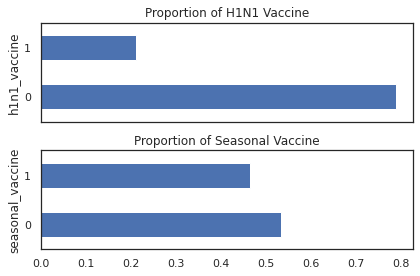

In [25]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [26]:
pd.crosstab(
    labels_df["h1n1_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [27]:
# Phi Coefficient is the same as Pearson for two binary variables
(labels_df["h1n1_vaccine"]
     .corr(labels_df["seasonal_vaccine"], method="pearson")
)

0.37714265306144507

In [28]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


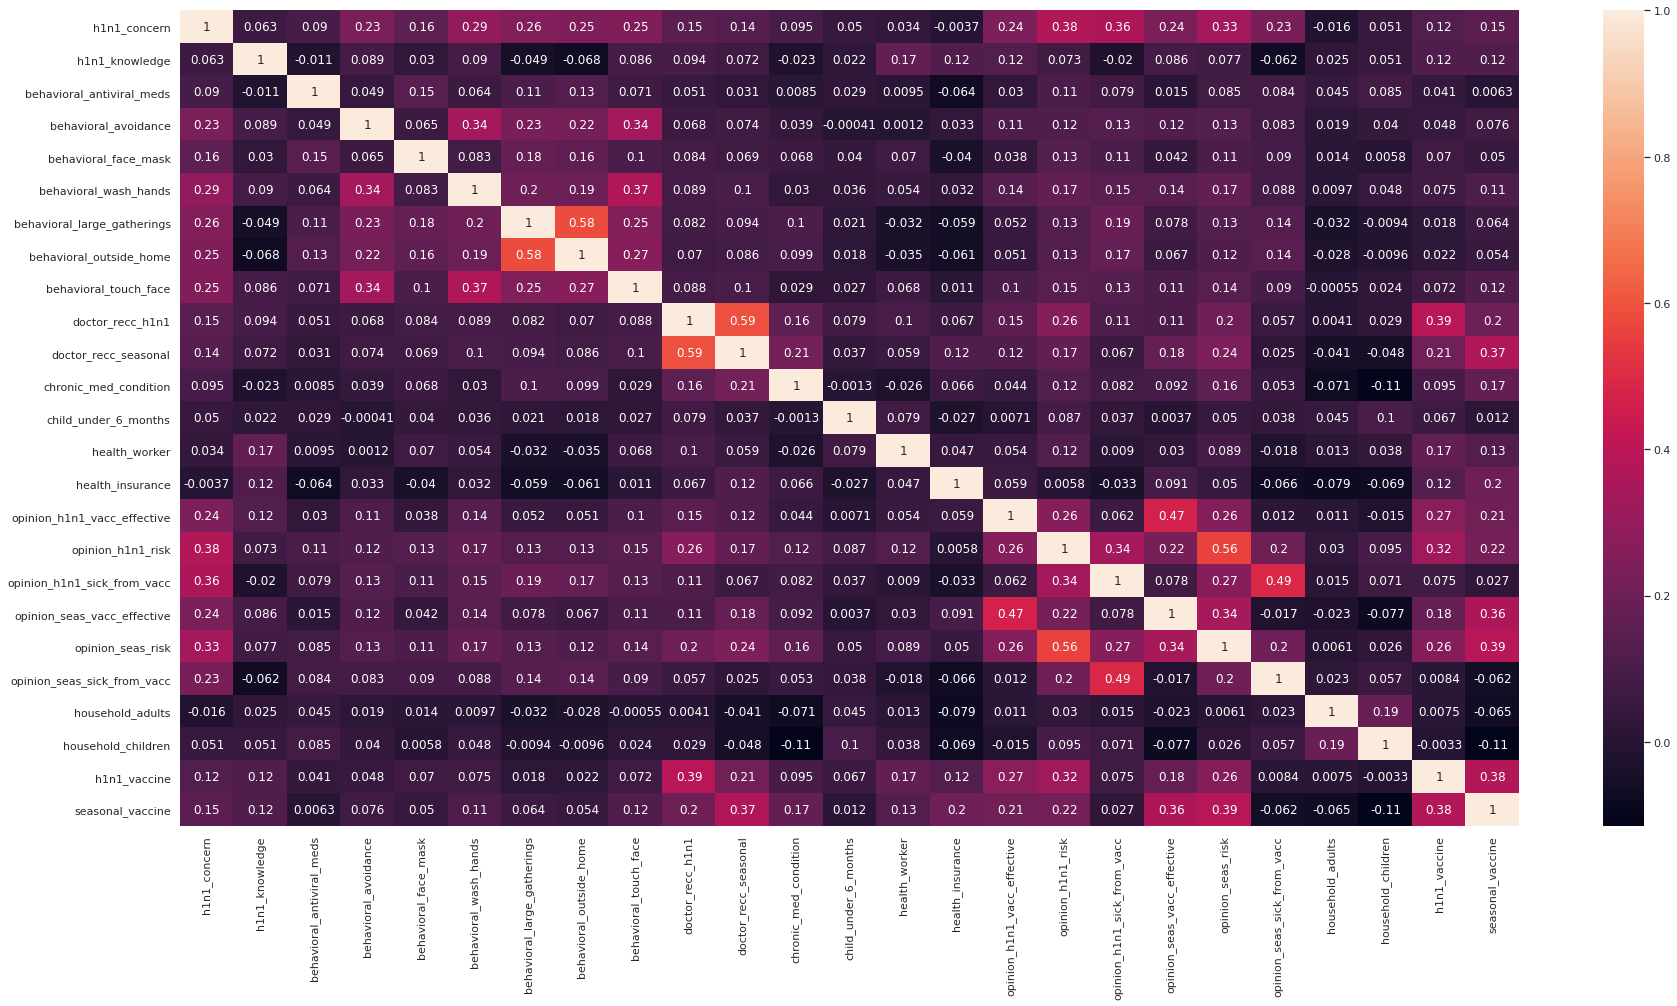

In [29]:
plt.figure(figsize=[30,15])
sns.heatmap(joined_df.corr(), annot=True)

In [30]:
counts = (joined_df[['employment_status', 'h1n1_vaccine']]
              .groupby(['employment_status', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
employment_status,,
Employed,10637,2923
Not in Labor Force,7988,2243
Unemployed,1216,237


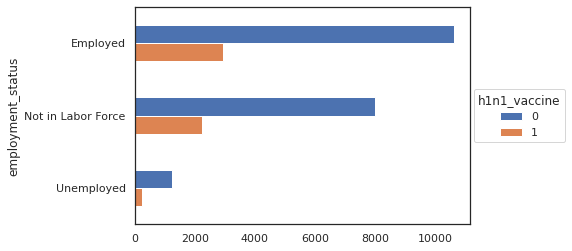

In [31]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


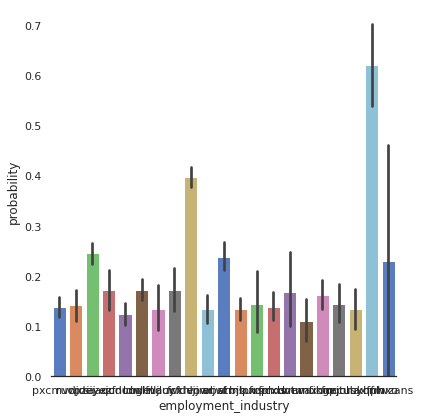

In [32]:
g = sns.factorplot(x="employment_industry",y="h1n1_vaccine",data=joined_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

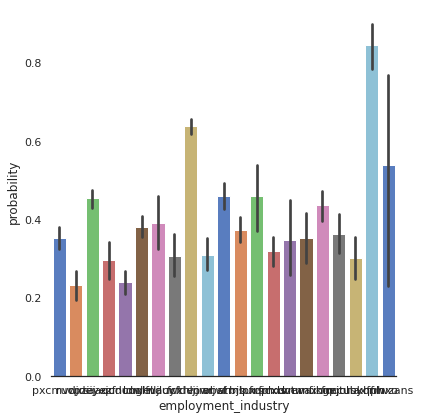

In [33]:
g = sns.factorplot(x="employment_industry",y="seasonal_vaccine",data=joined_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

In [34]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

employment_status
Employed              13560
Not in Labor Force    10231
Unemployed             1453
dtype: int64

In [35]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
employment_status,,
Employed,0.784440,0.215560
Not in Labor Force,0.780764,0.219236
Unemployed,0.836889,0.163111


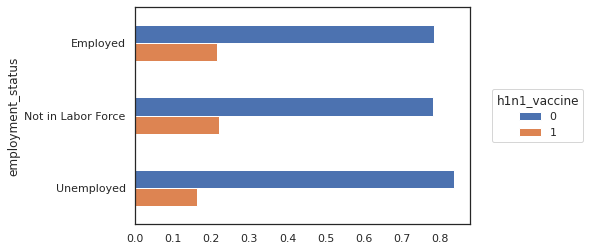

In [36]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

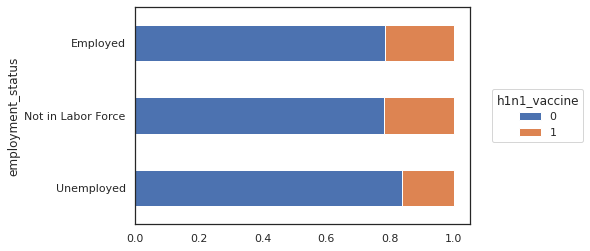

In [37]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [38]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

In [39]:
# cols_to_plot = [
#     #'h1n1_concern',
#     #'h1n1_knowledge',
#     #'opinion_h1n1_vacc_effective',
#     #'opinion_h1n1_risk',
#     #'opinion_h1n1_sick_from_vacc',
#     #'opinion_seas_vacc_effective',
#     #'opinion_seas_risk',
#     #'opinion_seas_sick_from_vacc',
#     #'sex',
#     #'age_group',
#     'race',
#    # 'education'
# ]

# fig, ax = plt.subplots(
#     len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
# )
# for idx, col in enumerate(cols_to_plot):
#     vaccination_rate_plot(
#         col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
#     )
#     vaccination_rate_plot(
#         col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
#     )
    
# ax[0, 0].legend(
#     loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
# )
# ax[0, 1].legend(
#     loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
# )
# fig.tight_layout()


------------------------------Modelling---------------------------------

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53415 entries, 0 to 53414
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 53238 non-null  float64
 1   h1n1_knowledge               53177 non-null  float64
 2   behavioral_antiviral_meds    53265 non-null  float64
 3   behavioral_avoidance         52994 non-null  float64
 4   behavioral_face_mask         53377 non-null  float64
 5   behavioral_wash_hands        53333 non-null  float64
 6   behavioral_large_gatherings  53256 non-null  float64
 7   behavioral_outside_home      53251 non-null  float64
 8   behavioral_touch_face        53159 non-null  float64
 9   doctor_recc_h1n1             49095 non-null  float64
 10  doctor_recc_seasonal         49095 non-null  float64
 11  chronic_med_condition        51512 non-null  float64
 12  child_under_6_months         51782 non-null  float64
 13  health_worker   

In [41]:
numeric_cols = dataset.columns[dataset.dtypes != "object"].values
#print(numeric_cols)

In [42]:
dataset=dataset[numeric_cols]

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53415 entries, 0 to 53414
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 53238 non-null  float64
 1   h1n1_knowledge               53177 non-null  float64
 2   behavioral_antiviral_meds    53265 non-null  float64
 3   behavioral_avoidance         52994 non-null  float64
 4   behavioral_face_mask         53377 non-null  float64
 5   behavioral_wash_hands        53333 non-null  float64
 6   behavioral_large_gatherings  53256 non-null  float64
 7   behavioral_outside_home      53251 non-null  float64
 8   behavioral_touch_face        53159 non-null  float64
 9   doctor_recc_h1n1             49095 non-null  float64
 10  doctor_recc_seasonal         49095 non-null  float64
 11  chronic_med_condition        51512 non-null  float64
 12  child_under_6_months         51782 non-null  float64
 13  health_worker   

In [44]:
h1n1_dataset = dataset
#h1n1_dataset = dataset.drop(['C_MSA, Not Principle  City','C_MSA, Principle City','C_Non-MSA'],axis='columns')#
#h1n1_dataset = dataset.drop(['C_MSA, Not Principle  City','C_MSA, Principle City','C_Non-MSA','age_group','household_adults','household_children','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc'],axis='columns')

In [45]:
h1n1_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53415 entries, 0 to 53414
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 53238 non-null  float64
 1   h1n1_knowledge               53177 non-null  float64
 2   behavioral_antiviral_meds    53265 non-null  float64
 3   behavioral_avoidance         52994 non-null  float64
 4   behavioral_face_mask         53377 non-null  float64
 5   behavioral_wash_hands        53333 non-null  float64
 6   behavioral_large_gatherings  53256 non-null  float64
 7   behavioral_outside_home      53251 non-null  float64
 8   behavioral_touch_face        53159 non-null  float64
 9   doctor_recc_h1n1             49095 non-null  float64
 10  doctor_recc_seasonal         49095 non-null  float64
 11  chronic_med_condition        51512 non-null  float64
 12  child_under_6_months         51782 non-null  float64
 13  health_worker   

In [46]:
h1n1_dataset.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,EI_phxvnwax,EI_pxcmvdjn,EI_qnlwzans,EI_rucpziij,EI_saaquncn,EI_vjjrobsf,EI_wlfvacwt,EI_wxleyezf,EI_xicduogh,EI_xqicxuve
count,53238.000000,53177.000000,53265.000000,52994.000000,53377.000000,53333.000000,53256.000000,53251.000000,53159.000000,49095.000000,...,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000
mean,1.620816,1.264287,0.049244,0.727705,0.069131,0.825849,0.355077,0.337271,0.680506,0.221489,...,0.003183,0.039596,0.000356,0.019863,0.012656,0.020481,0.007994,0.067565,0.031789,0.019433
std,0.906534,0.616881,0.216380,0.445145,0.253679,0.379243,0.478541,0.472783,0.466285,0.415253,...,0.056325,0.195009,0.018857,0.139532,0.111784,0.141641,0.089052,0.251001,0.175439,0.138042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
X_train = h1n1_dataset[:train_len]
test = h1n1_dataset[train_len:]

In [48]:
X_train.isnull().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
h

In [49]:
test.isnull().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
sex                                0
income_poverty                  4497
marital_status                  1442
rent_or_own                     2036
h

In [50]:
#X_train['education'] = X_train['education'].fillna(X_train.education.mean())
#test['education'] =test['education'].fillna(X_train.education.mean())

In [51]:
#X_train['marital_status'] = X_train['marital_status'].fillna(X_train.marital_status.mean())
#test['marital_status'] =test['marital_status'].fillna(X_train.marital_status.mean())

In [52]:
#fill missing values with mean
X_train= X_train.fillna(X_train.mean())
test= test.fillna(X_train.mean())

In [53]:
X_train.isnull().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
household_adults               0
household_children             0
R_Black                        0
R_Hispanic

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

In [55]:
y_train_h1n1=labels_df['h1n1_vaccine']
y_train_flu=labels_df['seasonal_vaccine']

In [56]:
#train for h1n1 and seasonal_flu done separately

y_train = y_train_h1n1 
#y_train = y_train_flu

In [57]:
#pca = PCA()
#pca.fit_transform(X_train)

In [58]:
#explained_variance=pca.explained_variance_ratio_
#explained_variance

In [59]:
#pca=PCA(n_components=20)
#X_train=pca.fit_transform(X_train)
#test=pca.transform(test)

In [60]:
kfold = StratifiedKFold(n_splits=10)

In [61]:
#upsampling method

example_params = {
        #'n_estimators': 100,
        #'max_depth': 5,
        #'random_state': 13
    }

def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=10, random_state=42)

    smoter = SMOTE(random_state=42)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = roc_auc_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [62]:
# Modeling step Test differents algorithms 
random_state = 2

In [63]:
classifiers = []
classifiers.append(XGBClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(RidgeClassifier())
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(naive_bayes.BernoulliNB())
classifiers.append(naive_bayes.GaussianNB())
classifiers.append(CatBoostClassifier())
classifiers.append(LGBMClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = 'roc_auc', cv = kfold, n_jobs=4)) #without upsampling
    #cv_results.append(score_model(classifier, example_params, cv=None))  #with upsampling

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [64]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees", "RidgeRegression","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression",
"LinearDiscriminantAnalysis","BNB","BNB" ,"CBC","LGBC"]}) 

In [65]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.857817,0.007885,XGB
1,0.836291,0.009855,SVC
2,0.686206,0.011832,DecisionTree
3,0.683809,0.011991,AdaBoost
4,0.857997,0.009249,RandomForest
5,0.850193,0.007644,ExtraTrees
6,0.832095,0.009768,RidgeRegression
7,0.867781,0.007747,GradientBoosting
8,0.805134,0.013914,MultipleLayerPerceptron
9,0.733059,0.014305,KNeighboors


ValueError: The lengths of the data (15) and the error 16 do not match

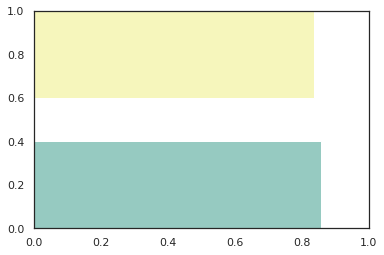

In [66]:
# g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
# g.set_xlabel("Mean Accuracy")
# g = g.set_title("Cross validation scores")

Do hyper parameter tuning for best classifiers chosen from above

In [ ]:
CBC = CatBoostClassifier()
cbc_param_grid = {
   "learning_rate"    : [0.05, 0.1, 0.15] , #[0.05]
   "depth"        : [3,4,5],  #[5]
   "iterations"     : [200,400,600], #[250] 
   "l2_leaf_reg" : [1,4,8]   #[2]
   #"gamma"            : [0.1,0.2,0.3] #[0.2]
  #"rsm" : [1.0 ]   #[] #[1]
    }

gsCBC = GridSearchCV(CBC,param_grid =cbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsCBC.fit(X_train,y_train)

CBC_best = gsCBC.best_estimator_

# Best score
gsCBC.best_score_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
CBC_best

In [ ]:
LGBC = LGBClassifier()()
lgbc_param_grid = {
   "learning_rate"    : [0.05, 0.1, 0.15] , #[0.05]
   "max_depth"        : [25,50,75],  #[5]
   "n_estimators"     : [200,400,600], #[250] 
    "min_data_in_leaf" : [300,600,900]   #[2]
  # "gamma"            : [0.1,0.2,0.3] #[0.2]
  #"colsample_bytree" : [1.0 ]   #[] #[1]
    }

gsLGBC = GridSearchCV(LGBC,param_grid =lgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsLGBC.fit(X_train,y_train)

LGBC_best = gsLGBC.best_estimator_

# Best score
gsLGBC.best_score_

In [ ]:
LGBC_best

In [ ]:
XGBC = XGBClassifier()
xgbc_param_grid = {
   "learning_rate"    : [0.1] , #[0.05]
   "max_depth"        : [5],  #[5]
   "n_estimators"     : [100], #[250] 
#    "min_child_weight" : [2],   #[2]
   "gamma"            : [0.2] #[0.2]
  #"colsample_bytree" : [1.0 ]   #[] #[1]
    }

gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsXGBC.fit(X_train,y_train)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

In [ ]:
XGBC_best

In [ ]:
GBC = GradientBoostingClassifier()
gbc_param_grid = {
    #"loss":["deviance"],
    "learning_rate": [0.1], #[0.05]
    #"min_samples_split": np.linspace(0.1, 0.5, 4),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[5], #[4]
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse", "mae"],
    #"subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[100] #[300]
    }

gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
GBC_best

In [ ]:
# RFC = RandomForestClassifier()
# rfc_param_grid = {
#    #'bootstrap': [True, False],
#    'max_depth': [10, 20, 30], #[20]
#    #'max_features': ['auto', 'sqrt'],
#    #'min_samples_leaf': [1, 2, 4],
#    #'min_samples_split': [2, 5, 10],
#    'n_estimators': [1350, 1250, 1300] # [1250]
#     }

# gsRFC = GridSearchCV(RFC,param_grid =rfc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsRFC.fit(X_train,y_train)

# RFC_best = gsRFC.best_estimator_

# # Best score
# gsRFC.best_score_

In [ ]:
# RFC_best

In [ ]:
# LR = LogisticRegression(random_state = random_state)
# lr_param_grid = {'penalty' : ['l1', 'l2'], 
#                    'solver' : ['liblinear', 'saga'],               
#                   'C': [1, 10, 50, 100, 300],
#                   'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]}

# gsLR = GridSearchCV(LR,param_grid =lr_param_grid, cv=kfold, scoring='roc_auc', n_jobs= 4, verbose = 1)

# gsLR.fit(X_train,y_train)

# LR_best = gsLR.best_estimator_

# # Best score
# gsLR.best_score_

In [ ]:
# LDA = LinearDiscriminantAnalysis()
# lda_param_grid = {'n_components' : [1, 2, 5, 10, 100], 
#                    'solver' : ['svd', 'lsqr','eigen']}

# gsLDA = GridSearchCV(LDA,param_grid =lda_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsLDA.fit(X_train,y_train)

# LDA_best = gsLDA.best_estimator_

# # Best score
# gsLDA.best_score_

In [ ]:
# RR = RidgeClassifier(random_state = random_state)
# rr_param_grid = {'solver' : ['liblinear', 'saga'],               
#                   'alpha' : [ 0.01, 0.1, 1, 5, 10, 50, 100]}

# gsRR = GridSearchCV(RR,param_grid =rr_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsRR.fit(X_train,y_train)

# RR_best = gsRR.best_estimator_

# # Best score
# gsRR.best_score_

In [ ]:
# ETC = ExtraTreesClassifier()
# etc_param_grid = {
#    #'bootstrap': [True, False],
#    'max_depth': [10, 20, 30], #[20]
#    #'max_features': ['auto', 'sqrt'],
#    #'min_samples_leaf': [1, 2, 4],
#    #'min_samples_split': [2, 5, 10],
#    'n_estimators': [1000, 1250, 1500] #[1000] [1500]
#     }

# gsETC = GridSearchCV(ETC,param_grid =etc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsETC.fit(X_train,y_train)

# ETC_best = gsETC.best_estimator_

# # Best score
# gsETC.best_score_

In [ ]:
# ETC_best

In [ ]:
# XGBC = XGBClassifier()
# xgbc_param_grid = {
#    "learning_rate"    : [0.05, 0.1, 0.3] , #[0.1] #[0.3]
#    "max_depth"        : [3, 5, 8],  #[5] #[3]
#     "n_estimators"  : [50, 100, 150], #[100] #[150]
#   #"min_child_weight" : [ 1],   #[] #[1]
#    "gamma"            : [ 0.0, 0.1, 0.2], #[0.2] #[0.2]
#   #"colsample_bytree" : [1.0 ]   #[] #[1]
#     }

# gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsXGBC.fit(X_train,y_train)

# XGBC_best = gsXGBC.best_estimator_

# # Best score
# gsXGBC.best_score_

In [ ]:
# XGBC_best

0.8643746746622861

In [ ]:
# GBC = GradientBoostingClassifier()
# gbc_param_grid = {
#     #"loss":["deviance"],
#     "learning_rate": [0.05, 0.1, 0.2], #[0.1] #[0.1]
#     #"min_samples_split": np.linspace(0.1, 0.5, 4),
#     #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
#     "max_depth":[4 , 5, 6], #[5] #[4]
#     #"max_features":["log2","sqrt"],
#     #"criterion": ["friedman_mse", "mae"],
#     #"subsample":[0.5, 0.8, 0.9, 1.0],
#     "n_estimators":[100, 200, 300] #[100] #[200]
#     }

# gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsGBC.fit(X_train,y_train)

# GBC_best = gsGBC.best_estimator_

# # Best score
# gsGBC.best_score_


0.8642818675050234

ensemble best moel

In [ ]:
# votingC = VotingClassifier(estimators=[('xgbc', XGBC_best),('gbc', GBC_best),('cbc', CBC_best)], voting='soft', n_jobs=4)

# votingC = votingC.fit(X_train, y_train)

votingC = CBC_best.fit(X_train, y_train)

In [ ]:
predics_h1n1 = votingC.predict_proba(test) #GBC_best.predict_proba(test)

In [ ]:
# predics_flu = votingC.predict_proba(test)#GBC_best.predict_proba(test)

In [ ]:
# submission_df["h1n1_vaccine"] = predics_h1n1[:,1]
# submission_df["seasonal_vaccine"] = predics_flu[:,1]

# submission_df.head()

# **Training for Flu**

In [ ]:
flu_dataset = dataset
#flu_dataset = dataset.drop(['C_MSA, Not Principle  City','C_MSA, Principle City','C_Non-MSA'],axis='columns')#

In [ ]:
X_train = flu_dataset [:train_len]
test = flu_dataset [train_len:]

In [ ]:
X_train= X_train.fillna(X_train.mean())
test= test.fillna(X_train.mean())

In [ ]:
# X_train_df = pd.DataFrame(X_train)
# test_df = pd.DataFrame(test)
# #['h1n1_vaccine'] = y_train_h1n1

In [ ]:
# X_train_df.head()

In [ ]:
# X_train_df['h1n1_vaccine'] = y_train_h1n1
# test_df['h1n1_vaccine'] = predics_h1n1[:,1]

In [ ]:
# test_df.head()

In [ ]:
# len(test_df)

In [ ]:
# len(X_train_df)

In [ ]:
# X_train = X_train_df[:len(X_train_df)]
# test = test_df[:len(test_df) ]

In [ ]:
# X_train = scaler.fit_transform(X_train)
# test = scaler.transform(test)

In [ ]:
y_train = y_train_flu

In [ ]:
#upsampling method

example_params = {
        #'n_estimators': 100,
        #'max_depth': 5,
        #'random_state': 13
    }

def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=10, random_state=42)

    smoter = SMOTE(random_state=42)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = roc_auc_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [ ]:
classifiers = []
classifiers.append(XGBClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(RidgeClassifier())
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(naive_bayes.BernoulliNB())
classifiers.append(naive_bayes.GaussianNB())
classifiers.append(CatBoostClassifier())
classifiers.append(LGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = 'roc_auc', cv = kfold, n_jobs=4)) #without upsampling
    #cv_results.append(score_model(classifier, example_params, cv=None))  #with upsampling

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [ ]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees", "RidgeRegression","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis",
                                                                                     "BNB","GNB" ,"CBC","LGBM"]})

In [ ]:
cv_res

In [ ]:
# g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
# g.set_xlabel("Mean Accuracy")
# g = g.set_title("Cross validation scores")

**Do hyper parameter tuning for best classifiers chosen from above****

In [ ]:
CBC = CatBoostClassifier()
cbc_param_grid = {
   "learning_rate"    : [0.05, 0.1, 0.15] , #[0.05]
   "depth"        : [3,4,5],  #[5]
   "iterations"     : [200,400,600], #[250] 
   "l2_leaf_reg" : [1,4,8],   #[2]
   #"gamma"            : [0.1,0.2,0.3] #[0.2]
  #"rsm" : [1.0 ]   #[] #[1]
    }

gsCBC = GridSearchCV(CBC,param_grid =cbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsCBC.fit(X_train,y_train)

CBC_best = gsCBC.best_estimator_

# Best score
gsCBC.best_score_

In [ ]:
CBC_best

In [ ]:
LGBC = LGBMClassifier()()
lgbc_param_grid = {
   "learning_rate"    : [0.05, 0.1, 0.15] , #[0.05]
   "max_depth"        : [25,50,75],  #[5]
   "n_estimators"     : [200,400,600], #[250] 
    "min_data_in_leaf" : [300,600,900]   #[2]
  # "gamma"            : [0.1,0.2,0.3] #[0.2]
  #"colsample_bytree" : [1.0 ]   #[] #[1]
    }

gsLGBC = GridSearchCV(LGBC,param_grid =lgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsLGBC.fit(X_train,y_train)

LGBC_best = gsLGBC.best_estimator_

# Best score
gsLGBC.best_score_

In [ ]:
LGBC_best

In [ ]:
XGBC = XGBClassifier()
xgbc_param_grid = {
   "learning_rate"    : [0.3] , #[0.1] 
   "max_depth"        : [3],         #[3]
   "n_estimators"    : [150],    #[100] 
#    "min_child_weight" : [ 1,2],              #[1] 
   "gamma"            : [ 0.2],  #[0.4]
  #"colsample_bytree" : [1.0 ]   #[] #[1]
    }

gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsXGBC.fit(X_train,y_train)

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

In [ ]:
XGBC_best

In [ ]:
GBC = GradientBoostingClassifier()
gbc_param_grid = {
    #"loss":["deviance"],
    "learning_rate": [0.1], #[0.1] #[0.1]
    #"min_samples_split": np.linspace(0.1, 0.5, 4),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[4], #[5] #[4]
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse", "mae"],
    #"subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[200] #[100] #[200]
    }

gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
GBC_best

In [ ]:
# LR = LogisticRegression(random_state = random_state)
# lr_param_grid = {'penalty' : ['l1', 'l2'], 
#                    'solver' : ['liblinear', 'saga'],               
#                   'C': [1, 10, 50, 100, 300],
#                   'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]}

# gsLR = GridSearchCV(LR,param_grid =lr_param_grid, cv=kfold, scoring='roc_auc', n_jobs= 4, verbose = 1)

# gsLR.fit(X_train,y_train)

# LR_best = gsLR.best_estimator_

# # Best score
# gsLR.best_score_

In [ ]:
# LR_best

In [ ]:
# gsLR.best_score_

In [ ]:
# LDA = LinearDiscriminantAnalysis()
# lda_param_grid = {'n_components' : [1, 2, 5, 10, 100], 
#                    'solver' : ['svd', 'lsqr','eigen']}

# gsLDA = GridSearchCV(LDA,param_grid =lda_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsLDA.fit(X_train,y_train)

# LDA_best = gsLDA.best_estimator_

# # Best score
# gsLDA.best_score_

In [ ]:
# LDA_best

In [ ]:
# gsLDA

In [ ]:
# RR = RidgeClassifier(random_state = random_state)
# rr_param_grid = {'solver' : ['liblinear', 'saga'],               
#                   'alpha' : [ 0.01, 0.1, 1, 5, 10, 50, 100]}

# gsRR = GridSearchCV(RR,param_grid =rr_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsRR.fit(X_train,y_train)

# RR_best = gsRR.best_estimator_

# # Best score
# gsRR.best_score_

In [ ]:
# RR_best

In [ ]:
# ETC = ExtraTreesClassifier()
# etc_param_grid = {
#    #'bootstrap': [True, False],
#    'max_depth': [10, 20, 30], #[20]
#    #'max_features': ['auto', 'sqrt'],
#    #'min_samples_leaf': [1, 2, 4],
#    #'min_samples_split': [2, 5, 10],
#    'n_estimators': [1000, 1250, 1500] #[1000] [1500]
#     }

# gsETC = GridSearchCV(ETC,param_grid =etc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsETC.fit(X_train,y_train)

# ETC_best = gsETC.best_estimator_

# # Best score
# gsETC.best_score_

In [ ]:
# ETC_best

In [ ]:
# RFC = RandomForestClassifier()
# rfc_param_grid = {
#    #'bootstrap': [True, False],
#    'max_depth': [10, 20, 50], #[20] [20]
#    #'max_features': ['auto', 'sqrt'],
#    #'min_samples_leaf': [1, 2, 4],
#    #'min_samples_split': [2, 5, 10],
#    'n_estimators': [1000, 1250, 1500] #[1000] [1250]
#     }

# gsRFC = GridSearchCV(RFC,param_grid =rfc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsRFC.fit(X_train,y_train)

# RFC_best = gsRFC.best_estimator_

# # Best score
# gsRFC.best_score_

In [ ]:
# RFC_best

In [ ]:
# XGBC = XGBClassifier()
# xgbc_param_grid = {
#    "learning_rate"    : [0.05, 0.1, 0.3] , #[0.1] #[0.3]
#    "max_depth"        : [3, 5, 8],  #[5] #[3]
#     "n_estimators"  : [50, 100, 150], #[100] #[150]
#   #"min_child_weight" : [ 1],   #[] #[1]
#    "gamma"            : [ 0.0, 0.1, 0.2], #[0.2] #[0.2]
#   #"colsample_bytree" : [1.0 ]   #[] #[1]
#     }

# gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsXGBC.fit(X_train,y_train)

# XGBC_best = gsXGBC.best_estimator_

# # Best score
# gsXGBC.best_score_

In [ ]:
# XGBC_best

In [ ]:
# GBC = GradientBoostingClassifier()
# gbc_param_grid = {
#     #"loss":["deviance"],
#     "learning_rate": [0.05, 0.1, 0.2], #[0.1] #[0.1]
#     #"min_samples_split": np.linspace(0.1, 0.5, 4),
#     #"min_samples_leaf": np.linspace(0.1, 0.5, 4),
#     "max_depth":[4 , 5, 6], #[5] #[4]
#     #"max_features":["log2","sqrt"],
#     #"criterion": ["friedman_mse", "mae"],
#     #"subsample":[0.5, 0.8, 0.9, 1.0],
#     "n_estimators":[100, 200, 300] #[100] #[200]
#     }

# gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

# gsGBC.fit(X_train,y_train)

# GBC_best = gsGBC.best_estimator_

# # Best score
# gsGBC.best_score_

In [ ]:
# GBC_best

In [ ]:
# votingC = VotingClassifier(estimators=[('xgbc', XGBC_best),('gbc', GBC_best),('cbc', CBC_best)], voting='soft', n_jobs=4)

# votingC = votingC.fit(X_train, y_train)

votingC = CBC_best.fit(X_train, y_train)

In [ ]:
predics_flu = votingC.predict_proba(test)#GBC_best.predict_proba(test)

In [ ]:
# submission_df["seasonal_vaccine"] = predics_flu[:,1]

# submission_df.head()

In [ ]:
submission_df["h1n1_vaccine"] = predics_h1n1[:,1]
submission_df["seasonal_vaccine"] = predics_flu[:,1]

submission_df.head()

In [ ]:
test_features_df['h1n1_vaccine'] = predics_h1n1[:,1]
test_features_df['seasonal_vaccine'] = predics_flu[:,1]

In [ ]:
output_df = test_features_df.drop(test_features_df.columns.difference(['h1n1_vaccine','seasonal_vaccine']), 1, inplace=True)
# output_df.head()
output_df

In [ ]:
test_features_df.head()

In [ ]:
test_features_df.to_csv('cbc_result.csv', index=True)